<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

# Dirichlet prior as database

BNLearner gives access of many priors for the parameters and structural learning. One of them is the Dirichlet prior which needs a a prior for every possible parameter in a BN. aGrUM/pyAgrum allows to use a database as a source of Dirichlet prior.

In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

import os

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

sizePrior=30000
sizeData=20000

## generating databases for Dirichlet prior and for the learning 

In [2]:
bnPrior = gum.fastBN("A->B;C;D")
bnData = gum.fastBN("A->B->C->D")
bnData.cpt("B").fillWith([0.99,0.01,
                          0.01,0.99])
bnData.cpt("C").fillWith([0.9,0.1,
                          0.1,0.9])
bnData.cpt("D").fillWith([0.9,0.1,
                          0.1,0.9])
bnPrior.cpt("B").fillWith(bnData.cpt("B"))

gum.generateCSV(bnPrior, "dirichlet.csv", sizePrior, with_labels=True,random_order=True)

gum.generateCSV(bnData, "database.csv", sizeData, with_labels=True,random_order=False)

gnb.sideBySide(bnData,bnPrior,
               captions=[f"Database ({sizeData} cases)",f"Prior ({sizePrior} cases)"])

G <!-- A --> A A <!-- B --> B B <!-- A->B --> A->B <!-- C --> C C <!-- B->C --> B->C <!-- D --> D D <!-- C->D --> C->D,G <!-- A --> A A <!-- B --> B B <!-- A->B --> A->B <!-- C --> C C <!-- D --> D D
Database (20000 cases),Prior (30000 cases)


## Learning databases

In [3]:
# bnPrior is used to give the variables and their domains
learnerData = gum.BNLearner("database.csv") 
learnerPrior = gum.BNLearner("dirichlet.csv") 
learnerData.useScoreBIC()
learnerPrior.useScoreBIC()
gnb.sideBySide(learnerData.learnBN(),learnerPrior.learnBN(),
              captions=["Learning from Data","Learning from Prior"])

G <!-- A --> A A <!-- B --> B B <!-- A->B --> A->B <!-- C --> C C <!-- C->A --> C->A <!-- C->B --> C->B <!-- D --> D D <!-- C->D --> C->D,G <!-- A --> A A <!-- B --> B B <!-- B->A --> B->A <!-- D --> D D <!-- C --> C C
Learning from Data,Learning from Prior


## Learning with Dirichlet prior

Now we use the Dirichlet prior. In order to have an idea of the influence of the priori, we change the weights of Data and Prior from [0,1] to [1,0] using a $ratio \in [0,1]$.

In [4]:
def learnWithRatio(ratio):
    # bnPrior is used to give the variables and their domains
    learner = gum.BNLearner("database.csv", bnPrior) 
    learner.useAprioriDirichlet("dirichlet.csv",ratio*sizePrior)
    learner.setDatabaseWeight((1-ratio)*sizeData)
    learner.useScoreBIC() # or another score with no included prior
    return learner.learnBN()

ratios=[0.0,0.01,0.05,0.2,0.5,0.8,0.9,0.95,0.99,1.0]
bns=[learnWithRatio(r) for r in ratios]
gnb.sideBySide(*bns,
              captions=[*[f"with ratio {r}<br/> [datasize : {r*sizePrior+(1-r)*sizeData}]" for r in ratios]])


G <!-- A --> A A <!-- B --> B B <!-- A->B --> A->B <!-- C --> C C <!-- C->A --> C->A <!-- C->B --> C->B <!-- D --> D D <!-- C->D --> C->D,G <!-- A --> A A <!-- D --> D D <!-- A->D --> A->D <!-- B --> B B <!-- B->A --> B->A <!-- C --> C C <!-- B->C --> B->C <!-- C->D --> C->D,G <!-- A --> A A <!-- B --> B B <!-- A->B --> A->B <!-- C --> C C <!-- C->A --> C->A <!-- C->B --> C->B <!-- D --> D D <!-- C->D --> C->D <!-- D->A --> D->A,G <!-- A --> A A <!-- B --> B B <!-- A->B --> A->B <!-- C --> C C <!-- A->C --> A->C <!-- D --> D D <!-- A->D --> A->D <!-- C->B --> C->B <!-- C->D --> C->D,G <!-- A --> A A <!-- B --> B B <!-- A->B --> A->B <!-- D --> D D <!-- A->D --> A->D <!-- B->D --> B->D <!-- C --> C C <!-- C->A --> C->A <!-- C->B --> C->B <!-- C->D --> C->D,G <!-- A --> A A <!-- D --> D D <!-- A->D --> A->D <!-- B --> B B <!-- B->A --> B->A <!-- C --> C C <!-- C->A --> C->A <!-- C->B --> C->B <!-- C->D --> C->D,G <!-- A --> A A <!-- D --> D D <!-- A->D --> A->D <!-- B --> B B <!-- B->A --> B->A <!-- C --> C C <!-- C->B --> C->B <!-- C->D --> C->D,G <!-- A --> A A <!-- D --> D D <!-- A->D --> A->D <!-- B --> B B <!-- B->A --> B->A <!-- C --> C C <!-- B->C --> B->C <!-- C->D --> C->D,G <!-- A --> A A <!-- B --> B B <!-- B->A --> B->A <!-- C --> C C <!-- D --> D D,G <!-- A --> A A <!-- B --> B B <!-- B->A --> B->A <!-- C --> C C <!-- D --> D D
with ratio 0.0 [datasize : 20000.0],with ratio 0.01 [datasize : 20100.0],with ratio 0.05 [datasize : 20500.0],with ratio 0.2 [datasize : 22000.0],with ratio 0.5 [datasize : 25000.0],with ratio 0.8 [datasize : 28000.0],with ratio 0.9 [datasize : 29000.0],with ratio 0.95 [datasize : 29500.0],with ratio 0.99 [datasize : 29900.0],with ratio 1.0 [datasize : 30000.0]


The BNs learned when mixing the 2 data sources look much more complex than the data and the Dirichlet structures (with $ratio \in [0.01,0.99]$). It may seem odd. However, if one looks at the mutual information,

In [5]:
gnb.sideBySide(*[gnb.getInformation(bn) for bn in bns],
              captions=[*[f"with ratio {r}<br/> [datasize : {r*sizePrior+(1-r)*sizeData}]" for r in ratios]],
              valign="bottom")

with ratio 0.0 [datasize : 20000.0],with ratio 0.01 [datasize : 20100.0],with ratio 0.05 [datasize : 20500.0],with ratio 0.2 [datasize : 22000.0],with ratio 0.5 [datasize : 25000.0],with ratio 0.8 [datasize : 28000.0],with ratio 0.9 [datasize : 29000.0],with ratio 0.95 [datasize : 29500.0],with ratio 0.99 [datasize : 29900.0],with ratio 1.0 [datasize : 30000.0]


It is obvious that these arcs represent weak and spurious correlations due to mixing probabilities (see Wellman et Peacock (99)) that become weaker when the weight of the prior increases.

Another way to look at the mixing is to plot the Kullback-Leibler divergence between the learned BNs and the 2 templates ($bnData$ and $bnPrio$r)

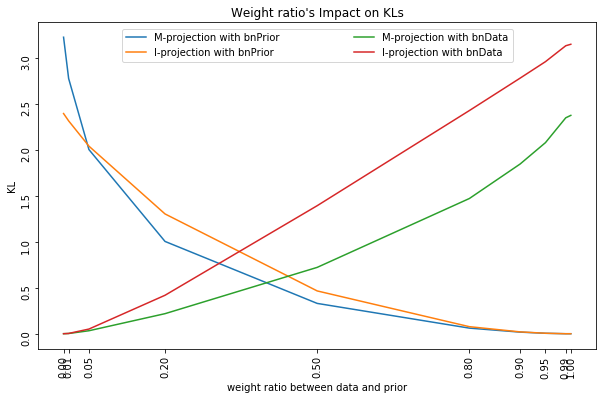

In [6]:
def kls(i):
    kl=gum.ExactBNdistance(bnPrior,bns[i])
    y1=kl.compute()
    kl=gum.ExactBNdistance(bnData,bns[i])
    y2=kl.compute()
    return y1['klPQ'],y2['klPQ'],y1['klQP'],y2['klQP']


fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)

x=ratios
y1,y2,y3,y4=zip(*[kls(i) for i in range(len(ratios))])
ax.plot(x,y1,label="M-projection with bnPrior")
ax.plot(x,y3,label="I-projection with bnPrior")
ax.plot(x,y2,label="M-projection with bnData")
ax.plot(x,y4,label="I-projection with bnData")
ax.set_xticks(ratios)
ax.tick_params(rotation=90)
ax.set_xlabel("weight ratio between data and prior")
ax.set_ylabel("KL")
ax.legend(bbox_to_anchor=(0.15, 0.88, 0.7, .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
t=ax.set_title("Weight ratio's Impact on KLs")

We can use other divergences (or distances)

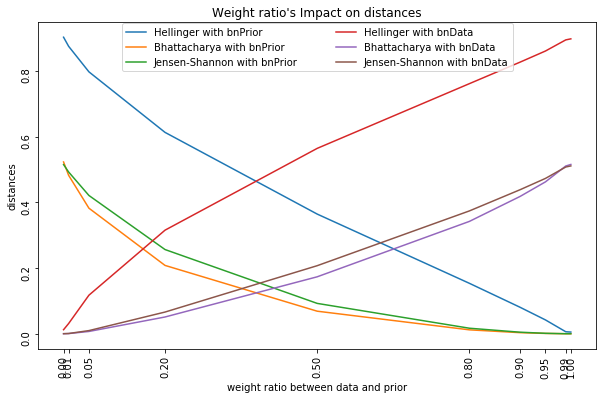

In [7]:
def distances(i):
    kl=gum.ExactBNdistance(bnPrior,bns[i])
    y1=kl.compute()
    kl=gum.ExactBNdistance(bnData,bns[i])
    y2=kl.compute()
    return y1['hellinger'],y2['hellinger'],y1['bhattacharya'],y2['bhattacharya'],y1['jensen-shannon'],y2['jensen-shannon']


fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)

x=ratios
y1,y2,y3,y4,y5,y6=zip(*[distances(i) for i in range(len(ratios))])
ax.plot(x,y1,label="Hellinger with bnPrior")
ax.plot(x,y3,label="Bhattacharya with bnPrior")
ax.plot(x,y5,label="Jensen-Shannon with bnPrior")
ax.plot(x,y2,label="Hellinger with bnData")
ax.plot(x,y4,label="Bhattacharya with bnData")
ax.plot(x,y6,label="Jensen-Shannon with bnData")
ax.set_xticks(ratios)
ax.tick_params(rotation=90)
ax.set_xlabel("weight ratio between data and prior")
ax.set_ylabel("distances")
ax.legend(bbox_to_anchor=(0.15, 0.85, 0.7, .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
t=ax.set_title("Weight ratio's Impact on distances")

Less informative but still possible, we can trace the scores (precision, etc.) from a gum.lib.gumComparator (see `07-ComparingBN` for more)

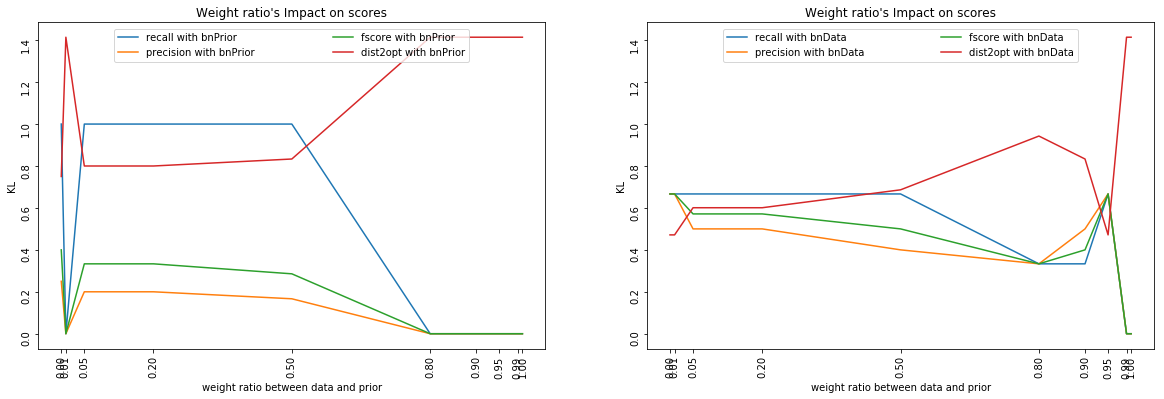

In [8]:
import pyAgrum.lib.bn_vs_bn as gcm

def scores(i):
    cmp=gcm.GraphicalBNComparator(bnPrior,bns[i])
    y1=cmp.scores()
    cmp=gcm.GraphicalBNComparator(bnData,bns[i])
    y2=cmp.scores()
    return y1['recall']   ,y2['recall'],y1['precision'],y2['precision'],y1['fscore'],y2['fscore'],y1['dist2opt'] ,y2['dist2opt']


fig=figure(figsize=(20,6))
ax1  = fig.add_subplot(1, 2, 1)
ax2  = fig.add_subplot(1, 2, 2)

x=ratios
y1,y2,y3,y4,y5,y6,y7,y8=zip(*[scores(i) for i in range(len(ratios))])
ax1.plot(x,y1,label="recall with bnPrior")
ax1.plot(x,y3,label="precision with bnPrior")
ax1.plot(x,y5,label="fscore with bnPrior")
ax1.plot(x,y7,label="dist2opt with bnPrior")

ax2.plot(x,y2,label="recall with bnData")
ax2.plot(x,y4,label="precision with bnData")
ax2.plot(x,y6,label="fscore with bnData")
ax2.plot(x,y8,label="dist2opt with bnData")

ax1.set_xticks(ratios)
ax1.tick_params(rotation=90)
ax1.set_xlabel("weight ratio between data and prior")
ax1.set_ylabel("KL")
ax1.legend(bbox_to_anchor=(0.15, 0.88, 0.7, .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
ax1.set_title("Weight ratio's Impact on scores")

ax2.set_xticks(ratios)
ax2.tick_params(rotation=90)
ax2.set_xlabel("weight ratio between data and prior")
ax2.set_ylabel("KL")
ax2.legend(bbox_to_anchor=(0.15, 0.88, 0.7, .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
ax2.set_title("Weight ratio's Impact on scores");

### Weighted database and records

Database can be weighted as done above. But you can also fix the weight record by record in the database. Note that the weight of database is the sum of all weights for each record. And then

```python
learner.setDatabaseWeight(2.5)
```

is equivalent to

```python
siz=learner.nbRows()
for i in range(siz):
    learner.setRecordWeight(i,2.5/siz)
```

In [9]:
bn=gum.fastBN("X->Y")

In the 2 next cells, we compute the parameters of bn using 2 bases : in the next cell, the base contains 8 rows of weight 1.
In the next one, the base contains only 4 rows but two of them have different weights. The sum of the weights in this second base is 8 as well ... 

So the parameters are exactly the same.

In [10]:
data="""X,Y
1,0
0,1
0,1
0,0
1,0
0,1
1,1
0,1
"""
with open("dataW.csv","w") as src:
    src.write(data)
learner=gum.BNLearner("dataW.csv")
bn1=learner.learnParameters(bn.dag())
gnb.sideBySide(bn1.cpt("X"),bn1.cpt("Y"))

In [11]:
data="""X,Y
0,0
1,0
0,1
1,1
"""
with open("dataW.csv","w") as src:
    src.write(data)    
learner=gum.BNLearner("dataW.csv")

learner.setRecordWeight(1,2.0)
learner.setRecordWeight(2,4.0)

bn2=learner.learnParameters(bn.dag())
gnb.sideBySide(bn2.cpt("X"),bn2.cpt("Y"))